## Librerias Usadas

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn.decomposition import PCA
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, auc as calcular_auc
from bayes_opt import BayesianOptimization
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import time
from imblearn.over_sampling import ADASYN
import matplotlib.pyplot as plt
import seaborn as sns
import ssl
import warnings
ssl._create_default_https_context = ssl._create_unverified_context
warnings.filterwarnings("ignore")

## Procesamiento de datos

In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/shadiajaafar1/ParcialML2/main/dataset_final%20(1).csv')
df.head()

,isFraud,TransactionDT,TransactionAmt,card2,card3,C3,C5,card4_american express,card4_discover,card4_mastercard,card4_visa,card6_credit,D3
0,0,86400,68.5,361.0,150.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,13.0
1,0,86401,29.0,404.0,150.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,8.0
2,0,86469,59.0,490.0,150.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,8.0
3,0,86499,50.0,567.0,150.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,0,86506,50.0,514.0,150.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,8.0


In [ ]:
# Verificando el balance de clases para la variable objetivo 'isFraud'
class_distribution = df['isFraud'].value_counts(normalize=True)
class_distribution

isFraud
0    0.96501
1    0.03499
Name: proportion, dtype: float64

In [4]:
X = df.drop('isFraud', axis=1)
y = df['isFraud']

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [6]:
# instanciando los modelos
bayes_clf = GaussianNB()
tree_clf = DecisionTreeClassifier(random_state=42)
forest_clf = RandomForestClassifier(random_state=42, n_jobs=-1)
xgboost_clf = XGBClassifier(random_state=42, n_jobs=-1)
knn_clf = KNeighborsClassifier(n_jobs=-1)
logistic_clf = LogisticRegression(solver='saga', penalty='elasticnet', l1_ratio=0.5, random_state=42)

In [7]:
# entrenando los modelos
bayes_clf.fit(X_train, y_train)
tree_clf.fit(X_train, y_train)
forest_clf.fit(X_train, y_train)
xgboost_clf.fit(X_train, y_train)
knn_clf.fit(X_train, y_train)
logistic_clf.fit(X_train, y_train) 

LogisticRegression(l1_ratio=0.5, penalty='elasticnet', random_state=42,
                   solver='saga')

In [8]:
modelos = [bayes_clf, tree_clf, forest_clf, xgboost_clf, knn_clf, logistic_clf]
nombres_modelos = ['Bayesian', 'Decision Tree', 'Random Forest', 'XGBoost', 'K-NN', 'Logistic Regression']

metricas = {}

for modelo, nombre in zip(modelos, nombres_modelos):
    y_pred = modelo.predict(X_test)
    reporte = classification_report(y_test, y_pred, output_dict=True)
    matriz_confusion = confusion_matrix(y_test, y_pred)
    auc = roc_auc_score(y_test, modelo.predict_proba(X_test)[:, 1])
    
    # Guardar en el diccionario
    metricas[nombre] = {
        'Precision': reporte['weighted avg']['precision'],
        'Recall': reporte['weighted avg']['recall'],
        'F1-Score': reporte['weighted avg']['f1-score'],
        'AUC': auc,
        'Matriz de Confusión': matriz_confusion
    }

metricas_df = pd.DataFrame.from_dict(metricas, orient='index')

metricas_df

,Precision,Recall,F1-Score,AUC,Matriz de Confusión
Bayesian,0.929457,0.964075,0.946450,0.574415,"[[113865, 1], [4242, 0]]"
Decision Tree,0.959502,0.957691,0.958565,0.716151,"[[111177, 2689], [2308, 1934]]"
Random Forest,0.968372,0.972610,0.967704,0.868008,"[[113390, 476], [2759, 1483]]"
XGBoost,0.961373,0.965786,0.951236,0.861542,"[[113816, 50], [3991, 251]]"
K-NN,0.944071,0.962695,0.948932,0.652481,"[[113486, 380], [4026, 216]]"
Logistic Regression,0.929457,0.964084,0.946454,0.478329,"[[113866, 0], [4242, 0]]"


- Bayesiano y Regresión Logística: Tienen AUCs bastante bajos, especialmente la regresión logística, que está muy cerca de 0.5.

- K-NN: Con un AUC de aproximadamente 0.65, muestra un rendimiento mejor que el azar, pero aún así es un valor moderadamente bajo para la mayoría de las aplicaciones prácticas.

- Árbol de Decisión: Muestra una mejora significativa con respecto a K-NN, con un AUC mayor que 0.7, lo que sugiere una capacidad de discriminación buena.

- Bosque Aleatorio y XGBoost: Estos dos modelos tienen los AUC más altos, ambos superiores a 0.85, lo que indica un excelente rendimiento en términos de discriminación entre las dos clases. 


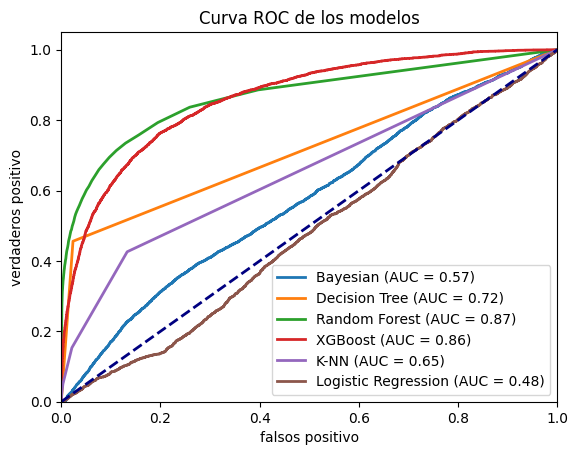

In [9]:
for modelo, nombre in zip(modelos, nombres_modelos):
    y_pred_probs = modelo.predict_proba(X_test)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_probs)
    roc_auc = calcular_auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'{nombre} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

plt.xlabel('falsos positivo')
plt.ylabel('verdaderos positivo')
plt.title('Curva ROC de los modelos')
plt.legend(loc="lower right")

plt.show()

- **Bayesiano (AUC = 0.57):** Está muy cerca de la línea de no-discriminación (diagonal punteada), lo que indica que no tiene un buen rendimiento para distinguir entre las clases.

- **Árbol de Decisión (AUC = 0.72):** Mejor que el Bayesiano pero aún con margen de mejora. Un AUC de 0.72 sugiere que el modelo tiene una capacidad razonable de distinguir entre las clases.

- **Random Forest (AUC = 0.87):** Muestra un buen rendimiento, con una capacidad mucho mejor para distinguir entre las clases en comparación con el Bayesiano y el Árbol de Decisión.

- **XGBoost (AUC = 0.86):** Similar al Bosque Aleatorio, XGBoost tiene un alto AUC, lo que sugiere que es muy eficaz en diferenciar las clases.

- **K-NN (AUC = 0.65):** Un rendimiento moderado, mejor que el azar, pero aún hay bastante espacio para mejorar en comparación con los métodos de ensamble como Bosque Aleatorio y XGBoost.

- **Regresión Logística (AUC = 0.48):** Este modelo está por debajo de la línea de no-discriminación, lo que sugiere que podría estar prediciendo peor que el azar, o que hay un problema con la manera en que se ha entrenado o configurado el modelo.

En conclusión, Random Forest y XGBoost son los que tienen mejor desempeño entre los presentados, mientras que la Regresión Logística tiene el rendimiento más bajo.

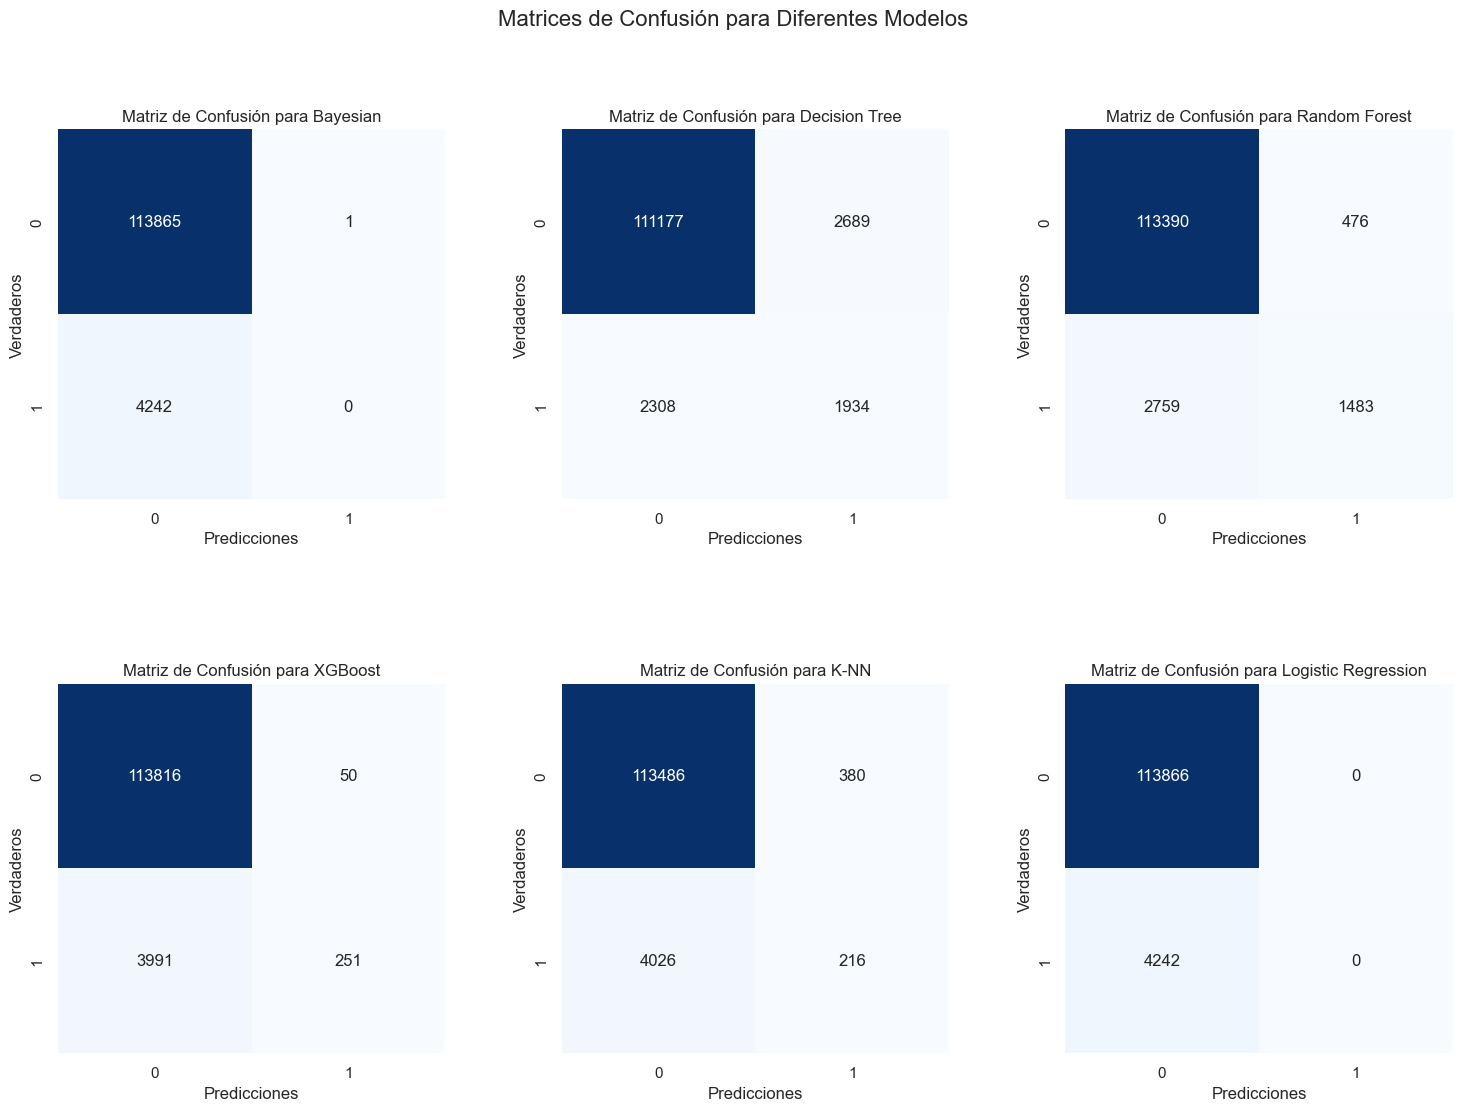

In [18]:
sns.set(style="white")

fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.subplots_adjust(hspace=0.5, wspace=0.3) 

for (modelo, nombre), ax in zip(zip(modelos, nombres_modelos), axes.flatten()):
    # Realizar las predicciones
    y_pred = modelo.predict(X_test)
    
    matriz_confusion = confusion_matrix(y_test, y_pred)

    sns.heatmap(matriz_confusion, annot=True, fmt="d", cmap="Blues", cbar=False, ax=ax)
    ax.set_title(f'Matriz de Confusión para {nombre}')
    ax.set_xlabel('Predicciones')
    ax.set_ylabel('Verdaderos')

plt.suptitle('Matrices de Confusión para Diferentes Modelos', fontsize=16)
plt.show()


Se observa que el modelo de Random Forest tiene el AUC más alto con 0.868008, lo que indica que tiene un buen rendimiento en la distinción entre las clases positivas y negativas. XGBoost también presenta un AUC relativamente alto con 0.861542. Los modelos Bayesian y Logistic Regression tienen el AUC más bajo, ambos con 0.574415 y 0.478329 respectivamente, lo que sugiere que son menos efectivos en la clasificación que los modelos de Random Forest y XGBoost, entonces el Random Forest sería la mejor opción de los presentados, seguido de cerca por XGBoost.

## Balanceo de datos y evaluación de modelos

In [19]:
adasyn = ADASYN(sampling_strategy='auto', random_state=42, n_neighbors=5)
X_resampled, y_resampled = adasyn.fit_resample(X, y)

In [20]:
pd.Series(y_resampled).value_counts(normalize=True)

isFraud
1    0.501233
0    0.498767
Name: proportion, dtype: float64

Podemos observar que los datos han sido balanceados, entonces la proporción de las observaciones en cada clase es casi similar

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

In [22]:
# instanciando los modelos
bayes_clf = GaussianNB()
tree_clf = DecisionTreeClassifier(random_state=42)
forest_clf = RandomForestClassifier(random_state=42, n_jobs=-1)
xgboost_clf = XGBClassifier(random_state=42, n_jobs=-1)
knn_clf = KNeighborsClassifier(n_jobs=-1)
logistic_clf = LogisticRegression(solver='saga', penalty='elasticnet', l1_ratio=0.5, random_state=42)

In [23]:
# entrenando los modelos
bayes_clf.fit(X_train, y_train)
tree_clf.fit(X_train, y_train)
forest_clf.fit(X_train, y_train)
xgboost_clf.fit(X_train, y_train)
knn_clf.fit(X_train, y_train)
logistic_clf.fit(X_train, y_train) 

LogisticRegression(l1_ratio=0.5, penalty='elasticnet', random_state=42,
                   solver='saga')

In [24]:
modelos = [bayes_clf, tree_clf, forest_clf, xgboost_clf, knn_clf, logistic_clf]
nombres_modelos = ['Bayesian', 'Decision Tree', 'Random Forest', 'XGBoost', 'K-NN', 'Logistic Regression']

metricas = {}

for modelo, nombre in zip(modelos, nombres_modelos):
    y_pred = modelo.predict(X_test)
    reporte = classification_report(y_test, y_pred, output_dict=True)
    matriz_confusion = confusion_matrix(y_test, y_pred)
    auc = roc_auc_score(y_test, modelo.predict_proba(X_test)[:, 1])

    metricas[nombre] = {
        'Precision': reporte['weighted avg']['precision'],
        'Recall': reporte['weighted avg']['recall'],
        'F1-Score': reporte['weighted avg']['f1-score'],
        'AUC': auc,
        'Matriz de Confusión': matriz_confusion
    }

metricas_df = pd.DataFrame.from_dict(metricas, orient='index')

metricas_df

,Precision,Recall,F1-Score,AUC,Matriz de Confusión
Bayesian,0.534101,0.508115,0.385281,0.584600,"[[6856, 107089], [5314, 109256]]"
Decision Tree,0.968683,0.968676,0.968676,0.968670,"[[110145, 3800], [3358, 111212]]"
Random Forest,0.980091,0.979923,0.979921,0.995368,"[[112717, 1228], [3360, 111210]]"
XGBoost,0.942592,0.940783,0.940728,0.985245,"[[110822, 3123], [10409, 104161]]"
K-NN,0.841587,0.833088,0.831998,0.911392,"[[85828, 28117], [10025, 104545]]"
Logistic Regression,0.711694,0.501560,0.335313,0.518588,"[[48, 113897], [4, 114566]]"


- **Bayesiano:** AUC de 0.584600 indica un rendimiento pobre.

- **Árbol de Decisión:** AUC de 0.968670 es muy alto, lo que sugiere que el modelo es excelente en la distinción entre las clases.

- **Random Forest:** AUC de 0.995368 indica un rendimiento excepcionalmente alto, casi perfecto, en la clasificación.

- **XGBoost:** AUC de 0.985245 también es muy alto, lo que refleja un rendimiento excelente en la clasificación.

- **K-NN:** AUC de 0.913192 muestra un buen rendimiento, aunque no tan alto como el de los modelos Random Forest y XGBoost.

- **Regresión Logística:** AUC de 0.518588 es ligeramente mejor que el azar, lo que indica un rendimiento muy pobre en la clasificación.

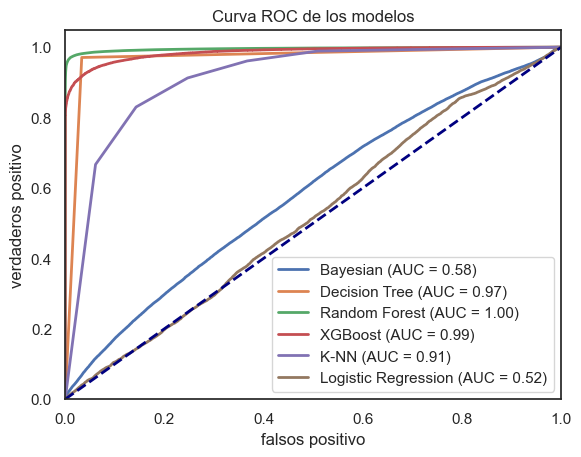

In [25]:
for modelo, nombre in zip(modelos, nombres_modelos):
    y_pred_probs = modelo.predict_proba(X_test)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_probs)
    roc_auc = calcular_auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'{nombre} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

plt.xlabel('falsos positivo')
plt.ylabel('verdaderos positivo')
plt.title('Curva ROC de los modelos')
plt.legend(loc="lower right")

plt.show()

Podemos observar en las curva ROC que Random Forest es la que tiene la mayor curva es decir es el mejor modelo para la clasificación y el que dio peor resultado es en la regresión logistica

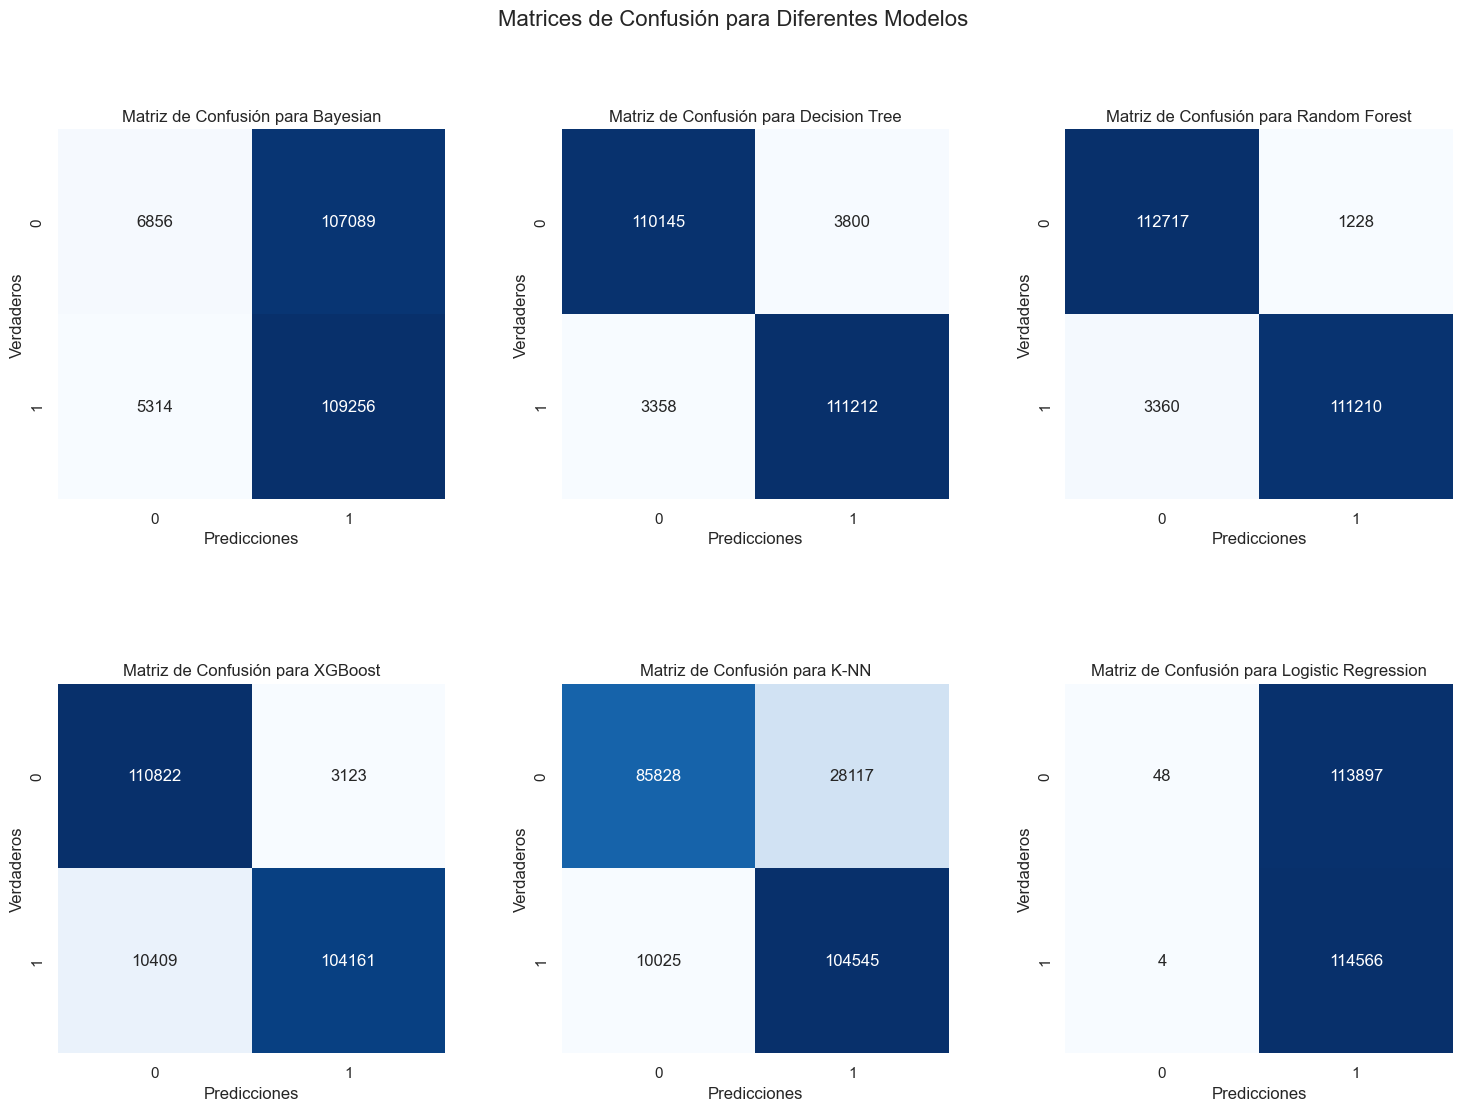

In [26]:
sns.set(style="white")

fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.subplots_adjust(hspace=0.5, wspace=0.3) 

for (modelo, nombre), ax in zip(zip(modelos, nombres_modelos), axes.flatten()):
    # Realizar las predicciones
    y_pred = modelo.predict(X_test)
    
    matriz_confusion = confusion_matrix(y_test, y_pred)

    sns.heatmap(matriz_confusion, annot=True, fmt="d", cmap="Blues", cbar=False, ax=ax)
    ax.set_title(f'Matriz de Confusión para {nombre}')
    ax.set_xlabel('Predicciones')
    ax.set_ylabel('Verdaderos')

plt.suptitle('Matrices de Confusión para Diferentes Modelos', fontsize=16)
plt.show()

- **Naive Bayes:** Este modelo parece tener una alta tasa de falsos positivos, lo que puede indicar una tendencia a predecir la clase positiva (1) con demasiada frecuencia.

- **Árbol de Decisión:** Con un equilibrio más razonable entre las predicciones de las clases positiva y negativa, el modelo del árbol de decisión tiene un desempeño decente, pero con un número no despreciable de falsos negativos y positivos.

- **Bosque Aleatorio:**
El bosque aleatorio muestra un muy buen desempeño con el número más alto de verdaderos negativos y verdaderos positivos entre los modelos presentados, y relativamente pocos errores de predicción en ambas clases.

- **XGBoost:** El XGBoost ha clasificado un número significativo de verdaderos positivos, pero también tiene un número relativamente alto de falsos negativos, lo que indica un cierto grado de sensibilidad hacia la clase negativa (0).

- **K-NN:** El K-NN tiene una cantidad considerable de falsos positivos, lo que sugiere que no es tan eficaz para mantener una baja tasa de errores de Tipo I (predicciones incorrectas de la clase positiva).

- **Regresión Logística:** La regresión logística muestra una matriz de confusión con muy pocos falsos positivos y negativos, lo que es excepcional.

## Hiperparametrización de los modelos
### Optimización Bayesiana
#### Clasificación Random Forest

In [79]:
def rf_cv(n_estimators, min_samples_leaf,min_samples_split, max_features, max_depth):

    estimator = RandomForestClassifier(
        n_estimators=int(n_estimators),
        min_samples_split=int(min_samples_split),
        min_samples_leaf=int(min_samples_leaf),
        max_features=min(max_features, 0.999),
        max_depth=int(max_depth),
        random_state=2,
        n_jobs=-1
    )
    c_val = cross_val_score(estimator, X_train, y_train, scoring='roc_auc', cv=5)
    
    return c_val.mean()

param_bounds = {
    'n_estimators': (10, 100), 
    'min_samples_split': (2, 10),
    'min_samples_leaf': (1, 20),
    'max_features': (0.1, 0.999),
    'max_depth': (10, 20),
}

optimizer = BayesianOptimization(
    f=rf_cv,
    pbounds=param_bounds,
    random_state=1,
)

# Iniciar la optimización bayesiana
optimizer.maximize(init_points=2, n_iter=10)

print(optimizer.max)

|   iter    |  target   | max_depth | max_fe... | min_sa... | min_sa... | n_esti... |
-------------------------------------------------------------------------------------
| 1         | 0.9813    | 14.17     | 0.7476    | 1.002     | 4.419     | 23.21     |
| 2         | 0.9638    | 10.92     | 0.2674    | 7.566     | 5.174     | 58.49     |
| 3         | 0.9813    | 14.99     | 0.7218    | 1.62      | 4.549     | 24.01     |
| 4         | 0.9727    | 20.0      | 0.1       | 20.0      | 10.0      | 10.0      |
| 5         | 0.9873    | 20.0      | 0.4628    | 20.0      | 7.878     | 100.0     |
| 6         | 0.9866    | 20.0      | 0.1008    | 2.773     | 2.767     | 100.0     |
| 7         | 0.9653    | 10.0      | 0.999     | 9.498     | 10.0      | 100.0     |
| 8         | 0.9788    | 20.0      | 0.1       | 13.66     | 2.0       | 100.0     |
| 9         | 0.9757    | 20.0      | 0.1       | 20.0      | 10.0      | 93.12     |
| 10        | 0.9878    | 20.0      | 0.1       | 1.0 

Aquí podemos observar los mejores hiperparámetros de acuerdo al rango de búsqueda establecido para el modelo random forest.

#### Clasificación Naive Bayes

In [33]:
def nb_cv(var_smoothing):
    estimator = GaussianNB(var_smoothing=var_smoothing)
    c_val = cross_val_score(estimator, X_train, y_train, scoring='roc_auc', cv=5)
    return c_val.mean()

param_bounds = {
    'var_smoothing': (1e-10, 1e-5)
}

optimizer = BayesianOptimization(
    f=nb_cv,
    pbounds=param_bounds,
    random_state=1,
)

# Iniciar la optimización bayesiana
optimizer.maximize(init_points=2, n_iter=10)

print(optimizer.max)

|   iter    |  target   | var_sm... |
-------------------------------------
| 1         | 0.5216    | 4.17e-06  |
| 2         | 0.5216    | 7.203e-06 |
| 3         | 0.5818    | 1.069e-09 |
| 4         | 0.603     | 5.713e-10 |
| 5         | 0.5701    | 1.519e-09 |
| 6         | 0.5908    | 8.228e-10 |
| 7         | 0.6371    | 2.037e-10 |
| 8         | 0.6034    | 5.647e-10 |
| 9         | 0.621     | 3.297e-10 |
| 10        | 0.5904    | 8.334e-10 |
| 11        | 0.5682    | 1.614e-09 |
| 12        | 0.5216    | 5.596e-06 |
{'target': 0.6371355578524981, 'params': {'var_smoothing': 2.0369278482312386e-10}}


Aquí podemos observar los mejores hiperparámetros de acuerdo al rango de búsqueda establecido para el modelo Naive Bayes.

#### Arbol de desición

In [35]:
def dt_cv(max_depth, min_samples_split, min_samples_leaf, max_features):
    estimator = DecisionTreeClassifier(
        max_depth=int(max_depth),
        min_samples_split=int(min_samples_split),
        min_samples_leaf=int(min_samples_leaf),
        max_features=min(max_features, 0.999),
        random_state=2
    )
    c_val = cross_val_score(estimator, X_train, y_train, scoring='roc_auc', cv=5)
    return c_val.mean()

param_bounds = {
    'max_depth': (3, 20), 
    'min_samples_split': (2, 10),
    'min_samples_leaf': (1, 20),
    'max_features': (0.1, 0.999),
}

optimizer = BayesianOptimization(
    f=dt_cv,
    pbounds=param_bounds,
    random_state=1,
)

optimizer.maximize(init_points=2, n_iter=10)

print(optimizer.max)

|   iter    |  target   | max_depth | max_fe... | min_sa... | min_sa... |
-------------------------------------------------------------------------
| 1         | 0.9569    | 10.09     | 0.7476    | 1.002     | 4.419     |
| 2         | 0.8432    | 5.495     | 0.183     | 4.539     | 4.764     |
| 3         | 0.9527    | 10.63     | 0.491     | 1.284     | 4.308     |
| 4         | 0.9678    | 12.01     | 0.999     | 1.0       | 9.124     |
| 5         | 0.9798    | 17.67     | 0.999     | 1.0       | 9.356     |
| 6         | 0.9821    | 18.53     | 0.999     | 6.742     | 10.0      |
| 7         | 0.9829    | 20.0      | 0.999     | 4.702     | 4.325     |
| 8         | 0.9843    | 20.0      | 0.999     | 11.91     | 5.01      |
| 9         | 0.947     | 20.0      | 0.1       | 16.75     | 10.0      |
| 10        | 0.9793    | 16.48     | 0.999     | 9.44      | 2.0       |
| 11        | 0.9767    | 15.64     | 0.999     | 16.95     | 2.0       |
| 12        | 0.9489    | 8.207     | 

Aquí podemos observar los mejores hiperparámetros de acuerdo al rango de búsqueda establecido para el modelo de árbol de desición.

### XGBoost

In [58]:
def xgb_cv(max_depth, min_child_weight, subsample, colsample_bytree, gamma, alpha, learning_rate):
    estimator = XGBClassifier(
        max_depth=int(max_depth),
        min_child_weight=int(min_child_weight),
        subsample=subsample,
        colsample_bytree=colsample_bytree,
        gamma=gamma,
        alpha=alpha,
        learning_rate=learning_rate,
        n_estimators=100,  
        random_state=2
    )
    c_val = cross_val_score(estimator, X_train, y_train, scoring='roc_auc', cv=5)
    return c_val.mean()

param_bounds = {
    'max_depth': (3, 10), 
    'min_child_weight': (1, 10),
    'subsample': (0.5, 1),
    'colsample_bytree': (0.5, 1),
    'gamma': (0, 5),
    'alpha': (0, 5),
    'learning_rate': (0.01, 0.3)
}

optimizer = BayesianOptimization(
    f=xgb_cv,
    pbounds=param_bounds,
    random_state=1,
)

# Iniciar la optimización bayesiana
optimizer.maximize(init_points=2, n_iter=10)

print(optimizer.max)

|   iter    |  target   |   alpha   | colsam... |   gamma   | learni... | max_depth | min_ch... | subsample |
-------------------------------------------------------------------------------------------------------------
| 1         | 0.9673    | 2.085     | 0.8602    | 0.0005719 | 0.09768   | 4.027     | 1.831     | 0.5931    |
| 2         | 0.9824    | 1.728     | 0.6984    | 2.694     | 0.1316    | 7.797     | 2.84      | 0.9391    |
| 3         | 0.9653    | 2.061     | 0.843     | 2.6       | 0.02605   | 7.95      | 2.877     | 0.7405    |
| 4         | 0.9847    | 3.826     | 0.5548    | 2.61      | 0.2328    | 7.81      | 2.197     | 0.601     |
| 5         | 0.9836    | 4.825     | 0.5331    | 0.2612    | 0.1873    | 7.053     | 8.747     | 0.7013    |
| 6         | 0.962     | 1.615     | 0.8564    | 2.4       | 0.01777   | 7.778     | 8.017     | 0.987     |
| 7         | 0.9726    | 2.207     | 0.7545    | 2.919     | 0.2534    | 3.019     | 8.362     | 0.5556    |
| 8       

Aquí podemos observar los mejores hiperparámetros de acuerdo al rango de búsqueda establecido para el modelo XGBoost.

#### KNN 

In [62]:
def knn_cv(n_neighbors, p):
    n_neighbors = int(round(n_neighbors))
    p = int(round(p))
    
    estimator = KNeighborsClassifier(
        n_neighbors=n_neighbors,
        p=p,
        n_jobs=-1
    )
    
    c_val = cross_val_score(estimator, X_train, y_train, scoring='roc_auc', cv=5).mean()
    
    return c_val

param_bounds = {
    'n_neighbors': (1, 50), 
    'p': (1, 2), 
}

knn_bo = BayesianOptimization(
    f=knn_cv,
    pbounds=param_bounds,
    random_state=42,
)

knn_bo.maximize(init_points=2, n_iter=10)

print(knn_bo.max)

|   iter    |  target   | n_neig... |     p     |
-------------------------------------------------
| 1         | 0.8684    | 19.35     | 1.951     |
| 2         | 0.8356    | 36.87     | 1.599     |
| 3         | 0.8684    | 19.28     | 1.942     |
| 4         | 0.8599    | 1.0       | 2.0       |
| 5         | 0.914     | 9.77      | 1.0       |
| 6         | 0.8859    | 12.45     | 1.987     |
| 7         | 0.8986    | 7.184     | 2.0       |
| 8         | 0.8447    | 50.0      | 1.0       |
| 9         | 0.8783    | 27.33     | 1.0       |
| 10        | 0.8938    | 9.446     | 2.0       |
| 11        | 0.9215    | 5.224     | 1.0       |
| 12        | 0.9015    | 4.439     | 2.0       |
{'target': 0.9214568345753162, 'params': {'n_neighbors': 5.224406222220528, 'p': 1.0}}


Aquí podemos observar los mejores hiperparámetros de acuerdo al rango de búsqueda establecido para el modelo de KNN.

#### Regresión logistica L1/L2

In [8]:
def logistic_cv(C, l1_ratio):
    
    estimator = LogisticRegression(
        C=C, 
        penalty='elasticnet', 
        l1_ratio=l1_ratio, 
        solver='saga', 
        max_iter=1000,  
        n_jobs=-1, 
        random_state=42
    )

    c_val = cross_val_score(estimator, X_train, y_train, scoring='roc_auc', cv=5, n_jobs=-1).mean()
    
    return c_val

param_bounds = {
    'C': (0.1, 2),  
    'l1_ratio': (0, 1), 
}

logistic_bo = BayesianOptimization(
    f=logistic_cv,
    pbounds=param_bounds,
    random_state=42,
)

logistic_bo.maximize(init_points=2, n_iter=5)

print(logistic_bo.max)

|   iter    |  target   |     C     | l1_ratio  |
-------------------------------------------------
| 1         | 0.4775    | 0.8116    | 0.9507    |
| 2         | 0.4775    | 1.491     | 0.5987    |
| 3         | 0.4775    | 0.1167    | 0.001725  |
| 4         | 0.4775    | 1.997     | 0.0003997 |
| 5         | 0.4775    | 0.1039    | 0.9774    |
| 6         | 0.4775    | 0.1107    | 0.4638    |
| 7         | 0.4775    | 1.229     | 0.9534    |
{'target': 0.4775327868476782, 'params': {'C': 0.8116262258099887, 'l1_ratio': 0.9507143064099162}}


Aquí podemos observar los mejores hiperparámetros de acuerdo al rango de búsqueda establecido para el modelo de regresión logística.

### Pipelines y Gridsearch

In [10]:
preprocessor = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=3)) 
])

param_grids = {
    'logistic': {
        'classifier': [LogisticRegression(solver='saga', penalty='elasticnet', max_iter=5000)],
        'classifier__C': [0.1, 1, 10],
        'classifier__l1_ratio': [0, 0.5, 1]
    },
    'knn': {
        'classifier': [KNeighborsClassifier()],
        'classifier__n_neighbors': [3, 5, 7],
        'classifier__p': [1, 2]
    },
    'decision_tree': {
        'classifier': [DecisionTreeClassifier()],
        'classifier__max_depth': [5, 10, 15],
        'classifier__min_samples_split': [2, 10, 20]
    },
    'random_forest': {
        'classifier': [RandomForestClassifier()],
        'classifier__n_estimators': [50, 100, 200],
        'classifier__max_features': ['sqrt', 'log2']
    },
    'xgboost': {
        'classifier': [GradientBoostingClassifier()],
        'classifier__n_estimators': [50, 100, 150],
        'classifier__learning_rate': [0.01, 0.1, 0.2]
    }
}

model_results = {}

for model_name, params in param_grids.items():
    pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                               ('classifier', params['classifier'][0])])
    grid_search = GridSearchCV(pipeline, param_grid={k: v for k, v in params.items() if k != 'classifier'}, cv=5, scoring='roc_auc', n_jobs=-1)
    grid_search.fit(X_train, y_train)
    model_results[model_name] = {
        'best_params': grid_search.best_params_,
        'best_score': grid_search.best_score_
    }

In [36]:
results = []
for model_name, params in param_grids.items():
    start_time = time.time()
    pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                               ('classifier', params['classifier'][0])])
    grid_search = GridSearchCV(pipeline, param_grid={k: v for k, v in params.items() if k != 'classifier'}, cv=5, scoring='roc_auc', n_jobs=-1)
    grid_search.fit(X_train, y_train)
    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test)
    y_proba = best_model.predict_proba(X_test)[:, 1] if hasattr(best_model['classifier'], "predict_proba") else [0] * len(y_test)
    elapsed_time = time.time() - start_time

    report = classification_report(y_test, y_pred, output_dict=True)
    auc_score = roc_auc_score(y_test, y_proba) if hasattr(best_model['classifier'], "predict_proba") else 'N/A'

    results.append({
        'Model': model_name,
        'Precision': report['weighted avg']['precision'],
        'Recall': report['weighted avg']['recall'],
        'F1-Score': report['weighted avg']['f1-score'],
        'AUC': auc_score,
        'Time (s)': elapsed_time,
        'Best Params': grid_search.best_params_
    })

In [52]:
results_df = pd.DataFrame(results)
results_df = results_df.sort_values(by='AUC', ascending=False)
results_df.drop('Best Params', axis=1)

,Model,Precision,Recall,F1-Score,AUC,Time (s)
3,random_forest,0.967648,0.971780,0.965397,0.816805,788.877758
4,xgboost,0.949640,0.964160,0.947281,0.760254,602.793634
2,decision_tree,0.952539,0.964566,0.949222,0.758873,41.876735
1,knn,0.953024,0.964634,0.954603,0.749210,33.457319
0,logistic,0.929457,0.964058,0.946441,0.667462,46.704683


- **Random Forest:** Tiene un AUC de 0.816805, lo que indica un muy buen rendimiento en términos de discriminación entre las clases positivas y negativas. Sin embargo, requiere el tiempo de cálculo más largo (aproximadamente 788.88 segundos).

- **XGBoost:** Muestra un AUC de 0.760254, lo cual es bueno y señala que es capaz de diferenciar entre las clases de manera efectiva, aunque no tan bien como el Random Forest. Su tiempo de cálculo es considerablemente más corto (aproximadamente 602.79 segundos).

- **Árbol de Decisión:** Tiene un AUC de 0.758873, que es comparable al de XGBoost y también indica un buen rendimiento. Notablemente, es mucho más rápido de calcular, tomando solo alrededor de 41.88 segundos. 

- **K-NN:** Con un AUC de 0.749210, este modelo también tiene un rendimiento decente. Es el segundo más rápido en términos de tiempo de cálculo, tomando solo alrededor de 33.46 segundos.

- **Regresión Logística:** Presenta el AUC más bajo (0.667462), lo que sugiere que tiene la peor capacidad entre los modelos presentados para distinguir entre las clases. No obstante, es el segundo modelo más rápido después de K-NN, con un tiempo de cálculo de aproximadamente 46.71 segundos.

In [58]:
for model_name, info in model_results.items():
    print(f"Modelo: {model_name}")
    print("Mejores Parámetros:")
    for param, value in info['best_params'].items():
        print(f"  {param}: {value}")
    print("") 


Modelo: logistic
Mejores Parámetros:
  classifier__C: 0.1
  classifier__l1_ratio: 0

Modelo: knn
Mejores Parámetros:
  classifier__n_neighbors: 7
  classifier__p: 1

Modelo: decision_tree
Mejores Parámetros:
  classifier__max_depth: 10
  classifier__min_samples_split: 20

Modelo: random_forest
Mejores Parámetros:
  classifier__max_features: log2
  classifier__n_estimators: 200

Modelo: xgboost
Mejores Parámetros:
  classifier__learning_rate: 0.2
  classifier__n_estimators: 150



Observamos los mejores hiperparámetros para cada modelo.

## Evaluación de modelos con los parámetros de la optimización bayesiana

In [ ]:
models = {
    'Random Forest': RandomForestClassifier(
        n_estimators=int(94.22),
        max_depth=20,
        min_samples_split=2,
        min_samples_leaf=1,
        max_features=0.1,
        random_state=42
    ),
    'Naive Bayes': GaussianNB(var_smoothing=2.0369278482312386e-10),
    'Decision Tree': DecisionTreeClassifier(
        max_depth=20,
        min_samples_split=int(5.009),
        min_samples_leaf=int(11.912),
        max_features=0.999,
        random_state=42
    ),
    'XGBoost': GradientBoostingClassifier(
        n_estimators=8,
        learning_rate=0.2327896660520686,
        subsample=0.6009623105089659,
        max_depth=int(7.809974212823236),
        min_samples_split=int(2),
        min_samples_leaf=int(2.196833866703887),
        random_state=42
    ),
    'K-NN': KNeighborsClassifier(
        n_neighbors=int(5.224),
        p=1
    ),
    'Logistic Regression': LogisticRegression(
        C=0.8116262258099887,
        l1_ratio=0.9507143064099162,
        penalty='elasticnet',
        solver='saga',
        max_iter=5000,
        random_state=42
    )
}

In [ ]:
results = {}
roc_curves = []

for name, model in models.items():
    start_time = time.time()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else None
    elapsed_time = time.time() - start_time
    
    results[name] = {
        'Report': classification_report(y_test, y_pred, output_dict=True),
        'Confusion Matrix': confusion_matrix(y_test, y_pred),
        'AUC': roc_auc_score(y_test, y_proba) if y_proba is not None else None,
        'Time': elapsed_time
    }
    
    if y_proba is not None:
        fpr, tpr, _ = roc_curve(y_test, y_proba)
        roc_curves.append((fpr, tpr, name))

In [15]:
data = []
for name, result in results.items():
    report = result['Report']
    data.append({
        'Model': name,
        'Precision': report['weighted avg']['precision'],
        'Recall': report['weighted avg']['recall'],
        'F1-Score': report['weighted avg']['f1-score'],
        'AUC': result['AUC'],
        'Time (s)': result['Time']
    })

df_metrics = pd.DataFrame(data)

df_metrics.sort_values(by='AUC', ascending=False, inplace=True)

display(df_metrics)

,Model,Precision,Recall,F1-Score,AUC,Time (s)
0,Random Forest,0.966413,0.967885,0.955670,0.884235,34.738714
3,XGBoost,0.952932,0.964693,0.949844,0.828551,5.726963
2,Decision Tree,0.954862,0.965100,0.956598,0.792557,2.099891
4,K-NN,0.947529,0.963457,0.950312,0.678319,5.803782
1,Naive Bayes,0.932455,0.963999,0.946428,0.647049,0.152396
5,Logistic Regression,0.929457,0.964084,0.946454,0.477625,908.990048


- **Random Forest:** Con un AUC de 0.884235, este modelo tiene el mejor rendimiento en términos de discriminación entre clases de todos los modelos listados. Esto significa que es el que tiene mayor probabilidad de distinguir correctamente entre las clases positiva y negativa.

- **XGBoost:** Tiene un AUC de 0.828551, que es alto y sugiere que el modelo también es muy bueno en la discriminación de las clases, aunque no tan eficiente como el Random Forest.

- **Árbol de Decisión:** Con un AUC de 0.792557, este modelo tiene un rendimiento bueno, pero es superado por los modelos de Random Forest y XGBoost.

- **K-NN:** Presenta un AUC de 0.678319, lo cual es moderadamente bueno, pero inferior a los modelos de árbol mencionados anteriormente.

- **Naive Bayes:** Tiene un AUC de 0.647049, lo que indica que su capacidad para distinguir entre las clases es relativamente baja en comparación con los otros modelos.

- **Regresión Logística:** Con un AUC de 0.477625, este modelo tiene la peor capacidad de discriminación entre las clases positivas y negativas de todos los modelos presentados.

Podemos ver que la regresión logística fue el modelo que más tardado, en comparación con los otros modelos.

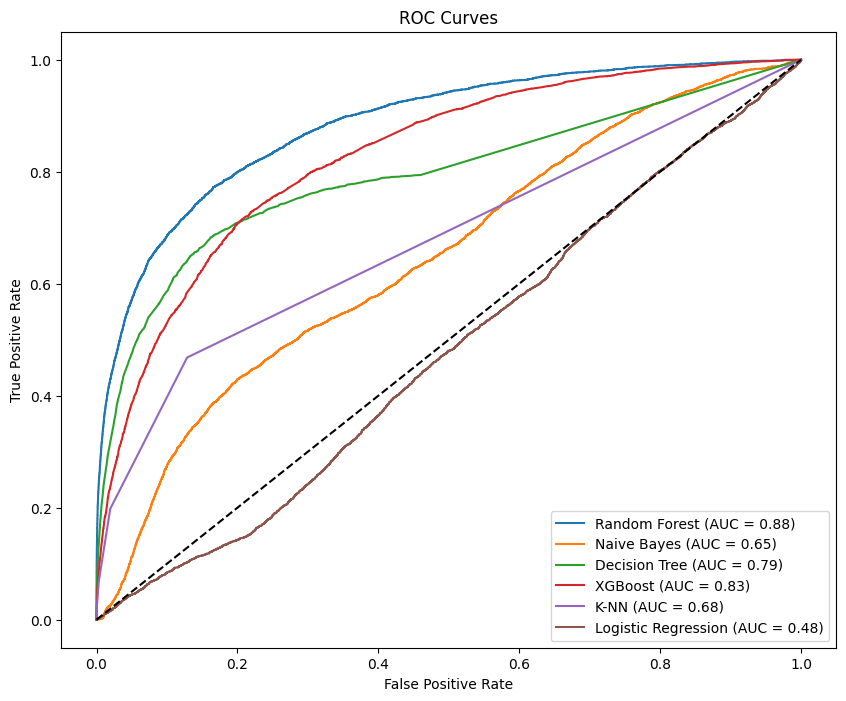

In [16]:
plt.figure(figsize=(10, 8))
for fpr, tpr, label in roc_curves:
    plt.plot(fpr, tpr, label=f'{label} (AUC = {results[label]["AUC"]:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend()
plt.show()

- **Random Forest:** Exhibe un rendimiento muy alto, con su curva situada cerca de la esquina superior izquierda, lo que significa que es capaz de diferenciar con gran efectividad entre las clases positivas y negativas.

- **Naive Bayes:** Tiene un rendimiento relativamente bueno en comparación con los otros modelos, con su curva bastante por encima de la línea de clasificación aleatoria pero por debajo de los otros clasificadores más eficaces.

- **Árbol de Decisión:** Muestra un buen rendimiento, no tan alto como el Bosque Aleatorio pero claramente mejor que un clasificador aleatorio.

- **XGBoost:** Presenta un rendimiento fuerte, aunque ligeramente inferior al del Bosque Aleatorio, lo cual sigue siendo un indicador de una buena capacidad de clasificación.

- **K-NN:** Su rendimiento es mejor que el de Naive Bayes, pero aún así está por debajo de los métodos basados en árboles, lo que indica una eficacia moderada en la clasificación.

- **Regresión Logística:** Tiene el peor rendimiento de todos los modelos presentados, su AUC está incluso por debajo del 0.5, lo que sugiere que podría estar clasificando peor que el azar. Este modelo requeriría una revisión para entender por qué su rendimiento es tan bajo.

Random Forest y XGBoost son los clasificadores más eficientes de este grupo, mientras que la Regresión Logística tiene problemas para clasificar.


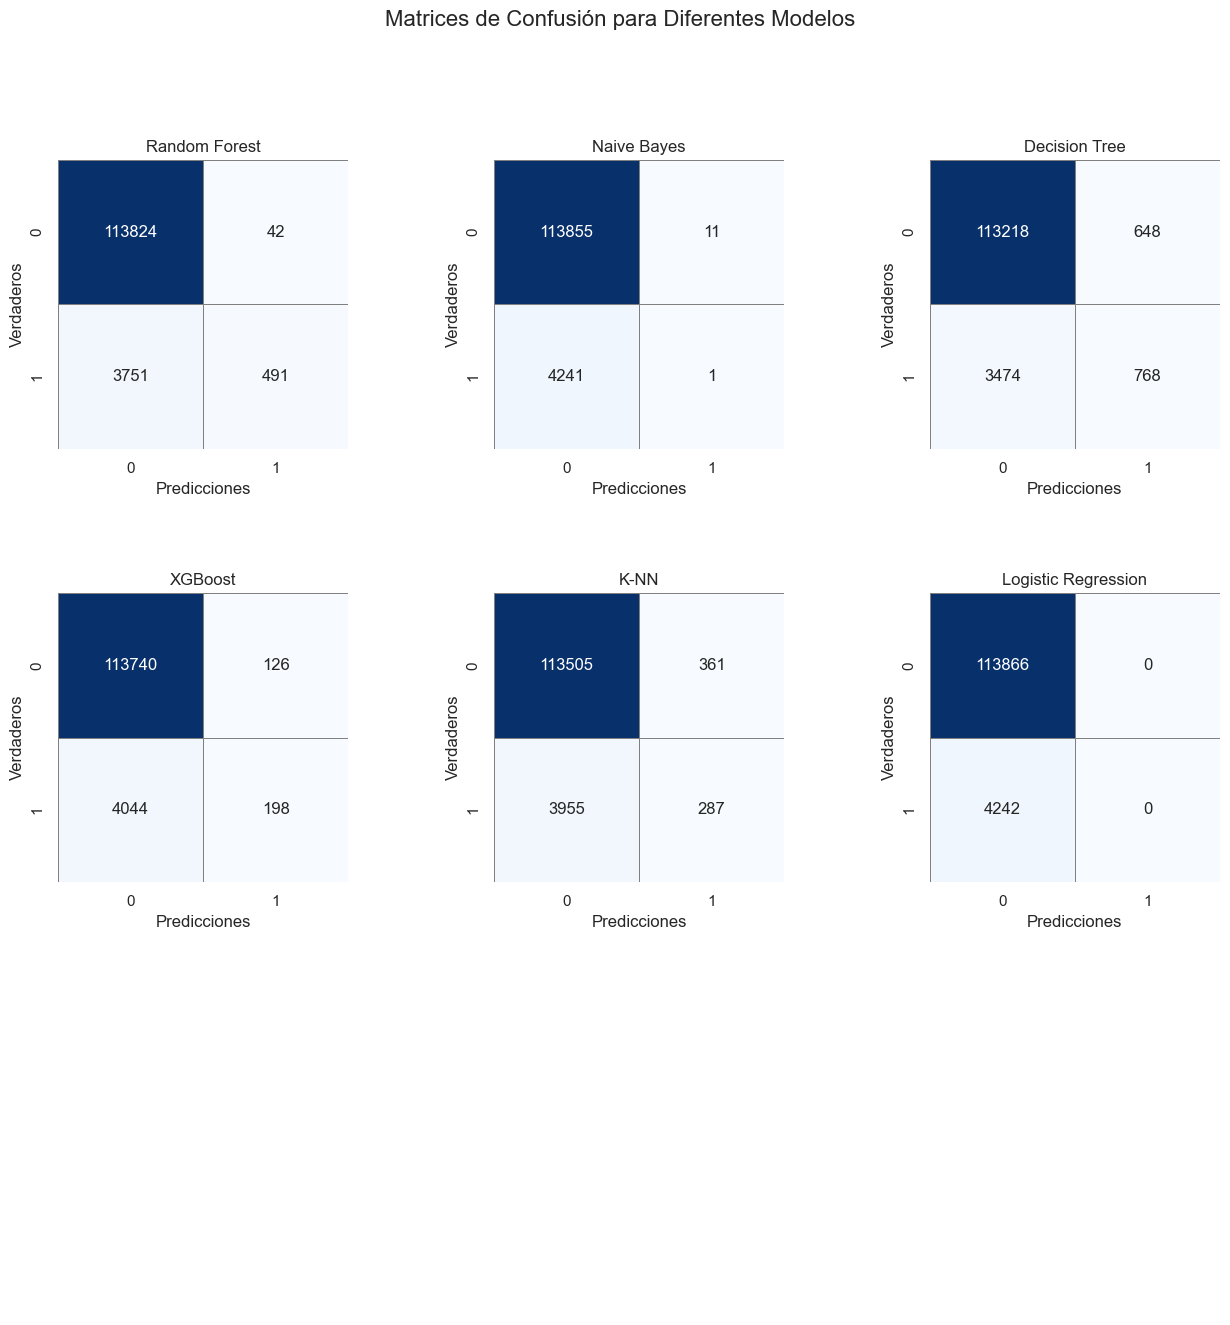

In [26]:
sns.set(style="white")

model_names = list(results.keys())
num_models = len(model_names)

fig, axes = plt.subplots(3, 3, figsize=(15, 15))  
fig.subplots_adjust(hspace=0.5, wspace=0.5)  

for i, ax in enumerate(axes.flatten()):
    if i < num_models:
        model_name = model_names[i]
        matrix = results[model_name]['Confusion Matrix']
        sns.heatmap(matrix, annot=True, fmt="d", cmap="Blues", cbar=False, ax=ax,
                    linewidths=.5, linecolor='gray')
        ax.set_title(f'{model_name}')
        ax.set_xlabel('Predicciones')
        ax.set_ylabel('Verdaderos')
    else:
        ax.axis('off') 

plt.suptitle('Matrices de Confusión para Diferentes Modelos', fontsize=16)
plt.show()


- **Random Forest:** Este modelo tiene un excelente desempeño en la clasificación de verdaderos negativos y mantiene un bajo número de falsos positivos, pero parece tener dificultades en identificar correctamente la clase positiva, como lo indica el número relativamente alto de falsos negativos.

- **Naive Bayes:** Naive Bayes también es muy bueno para identificar la clase negativa, con muy pocos FP, pero tiene un rendimiento extremadamente pobre en la identificación de la clase positiva.

- **Decision Tree:** El árbol de decisión tiene un buen número de VN y un VP moderado. Sin embargo, tiene más FP y FN que el modelo de bosque aleatorio, lo que sugiere un equilibrio menos óptimo entre la sensibilidad y la especificidad.

- **XGBoost:** XGBoost muestra una capacidad razonable para clasificar VNs y tiene un número de FP manejable. No obstante, al igual que el bosque aleatorio, lucha por clasificar los VPs correctamente, con un número significativo de FNs.

- **K-NN** El K-NN tiene un desempeño equilibrado con un número moderado de FP y FN. Aunque no es el mejor modelo, muestra una capacidad decente para clasificar ambas clases.

- **Regresión Logística:** La regresión logística presenta un caso extremo donde clasifica perfectamente la clase negativa, pero completamente ignora la clase positiva, sin VPs y un alto número de FNs.

### Conclusiones:

**Datos balanceados:**
- *Con y sin optimización bayesiana:* En general, cada modelo mostró una disminución en el AUC después de aplicar la optimización bayesiana.

- *Con y sin pipeline y Gridsearch:* los modelos con GridSearch y pipeline tienen AUC más bajos en comparación con los modelos sin estos procesos.

**Métodos de hiperparametrización:**
- *Grid search y Pipeline vs Optimización Bayesiana:* los valores de AUC son generalmente más altos en los resultados de la optimización bayesiana para todos los modelos excepto para la Regresión Logística. En cuanto al tiempo de cómputo, es generalmente más alto para los resultados de grid search, con el modelo Random Forest mostrando un aumento de tiempo muy significativo. Esto indica que, aunquee el grid search puede proporcionar resultados robustos, puede ser computacionalmente más costosa que la optimización bayesiana.

En general, de acuerdo con todos los AUC obtenidos el mejor modelo fue Random Forest